# Polar plot for one cell, one experiment

## Pick experiment and cell

In [1]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

In [18]:
exp_id = 501836392
ec_id = 511510650
cell_specimen_id = 517419703 # 517419533 #517419703
# https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating

In [19]:
import warnings;
warnings.simplefilter('ignore');
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
from utils.polardata import *
from utils.polarplot import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [20]:
exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
                                experiment_container_ids=[ec_id],
        targeted_structures = ['VISp'],
        imaging_depths = [175],
        cre_lines = ['Cux2-CreERT2'])
exps

[{'id': 501836392,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 108,
  'experiment_container_id': 511510650,
  'session_type': 'three_session_A',
  'donor_name': '222425',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222425',
  'fail_eye_tracking': True}]

In [21]:
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [22]:
cells[cells['cell_specimen_id'] == cell_specimen_id]

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
1673,False,VISp,517419703,Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...,0.370128,511510650,False,0.370128,1.0,0.87447,...,495727000,0.44284,0.23219,0.26536,177839004,Cux2-CreERT2,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [23]:
from utils.data_wrappers import *
dg_response_filter = get_dg_response_filter_from_saskia()
dg_response_filter[dg_response_filter['cell_specimen_id'] == cell_specimen_id]

,cell_specimen_id,responsive,pref_dir,pref_tf
30549,517419703,True,135.0,2.0


Hooray! We found cell **517416426** in experiment container **511510640**, where the experiment is **[dg, VISl, 175, Cux2-CreERT2]**, and the cell is **responsive**

## Polar plot

This cell's plot exactly matches allen's data! https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating.
Great! Our get_avg_normalized_response() is probably right :)

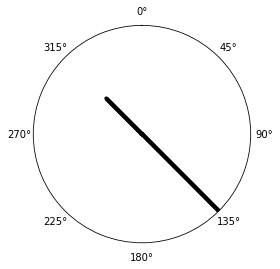

In [24]:
import warnings;
warnings.simplefilter('ignore');
polardata = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
theta, r = convert_polar_dict_to_arrays(polardata)
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot(axes, theta, r, color='black', linewidth=4)


In [25]:
polardata

orientation
0.0      0.001580
45.0     0.001862
90.0     0.003499
135.0    1.000000
180.0    0.000592
225.0    0.001428
270.0    0.001362
315.0    0.463992
Name: mean_dff, dtype: float64

In [26]:
get_new_dsi(polardata.to_frame())

0.36612737049667377

# Polar plot for all cells in one experiment

Apply **filtering** for cells in this experiment

In [14]:
exps = boc.get_ophys_experiments(
    experiment_container_ids=[ec_id],
    stimuli=[stim_info.DRIFTING_GRATINGS])
exps = pd.DataFrame.from_dict(exps)
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

dg_response_filter = get_dg_response_filter_from_saskia()
polardata_df = polardata.to_frame()

in_category_cells = cells[cells.experiment_container_id == ec_id]
filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
new_col = []
for index, row in filtered_cells.iterrows():
    polardata_for_this_cell = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = row.cell_specimen_id,
        temporal_frequency=2.0)
    if polardata_for_this_cell is None:
        # Put negative value so dsi selector will ignore this guy.
        new_dsi_cell = -1
    else:
        new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
    new_col.append(new_dsi_cell)
filtered_cells['new_dsi_cell'] = new_col
filtered_cells = filtered_cells[filtered_cells.new_dsi_cell > 0.5]

print ("In this experiment, we have", len(in_category_cells),
       "cells, but after filtering, we have", len(filtered_cells), "cells")


In this experiment, we have 243 cells, but after filtering, we have 28 cells


In [15]:
thetas = []
rs = []
cell_ids = []
for cell_specimen_id in filtered_cells.cell_specimen_id:
    one_cell_polar_data_dict = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
    if one_cell_polar_data_dict is None:
        continue
    theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
    thetas.append(theta)
    rs.append(r)
    cell_ids.append(cell_specimen_id)

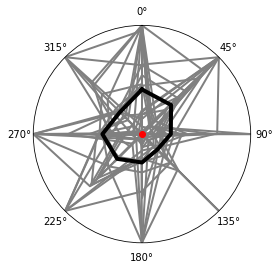

In [16]:
agg_theta, agg_r = get_avg_polar(thetas, rs)
# Or use get_median_polar

fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
                      bold_theta = agg_theta,
                      bold_r = agg_r,
                      grey_thetas = thetas, 
                      grey_rs = rs)

Let's see each cell's polar plot

cell id 517419064
g_dsi_dg 0.323180714314738
dsi_dg 0.666547309721309
p_dg 3.43202755221211e-23
pref_dir_dg 225.0
new_dsi_cell 0.7389698960442612


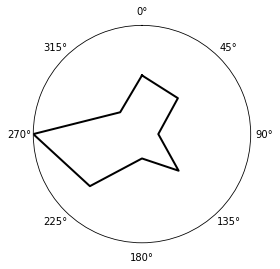

cell id 517419101
g_dsi_dg 0.894810181889737
dsi_dg 1.44419681790238
p_dg 1.06870295993582e-21
pref_dir_dg 45.0
new_dsi_cell 0.8312061843793533


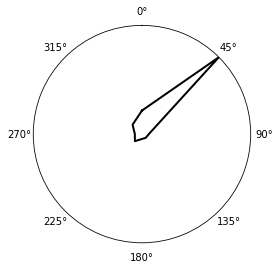

cell id 517419280
g_dsi_dg 0.494840215273413
dsi_dg 0.731129790554648
p_dg 0.00416057092823998
pref_dir_dg 0.0
new_dsi_cell 0.6056437631061456


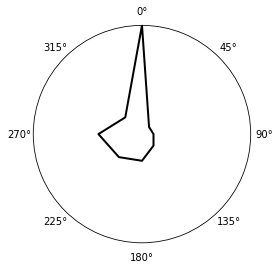

cell id 517419302
g_dsi_dg 0.313968613645282
dsi_dg 1.03324335003793
p_dg 0.00021714823462001
pref_dir_dg 225.0
new_dsi_cell 0.8138400201790341


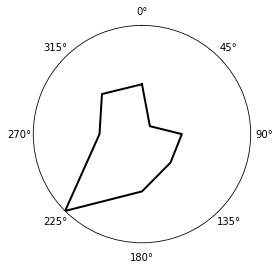

cell id 517419419
g_dsi_dg 0.682317843173677
dsi_dg nan
p_dg 0.617602220065511
pref_dir_dg nan
new_dsi_cell 0.8853869504691069


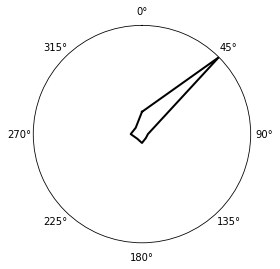

cell id 517419533
g_dsi_dg 0.569288812135067
dsi_dg 1.0813344160444
p_dg 1.57477262575506e-20
pref_dir_dg 0.0
new_dsi_cell 1.0


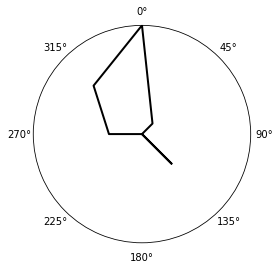

cell id 517419797
g_dsi_dg 0.33435870916249
dsi_dg 1.03920818885005
p_dg 1.72088502639276e-06
pref_dir_dg 0.0
new_dsi_cell 0.6907331947675721


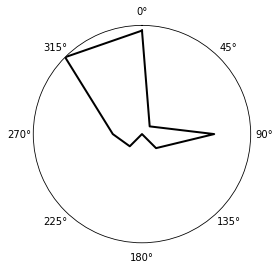

cell id 517419817
g_dsi_dg 0.797295562055789
dsi_dg 1.04114309258443
p_dg 2.95420559028729e-09
pref_dir_dg 0.0
new_dsi_cell 0.8126853122052788


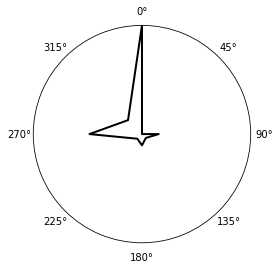

cell id 517419874
g_dsi_dg 0.372094090142186
dsi_dg 0.442250428138136
p_dg 1.01716847594296e-14
pref_dir_dg 270.0
new_dsi_cell 0.6911491043959268


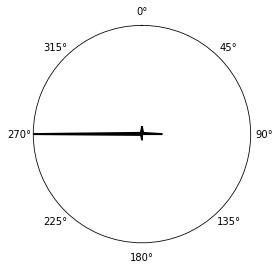

cell id 517420095
g_dsi_dg 0.521825842094179
dsi_dg 1.15859936304583
p_dg 2.14210070921324e-37
pref_dir_dg 135.0
new_dsi_cell 0.8652061160754156


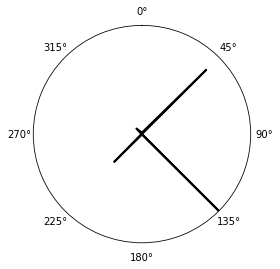

cell id 517420158
g_dsi_dg 0.543926685112805
dsi_dg 0.640976583177879
p_dg 2.27464946630592e-07
pref_dir_dg 0.0
new_dsi_cell 0.7673736904287888


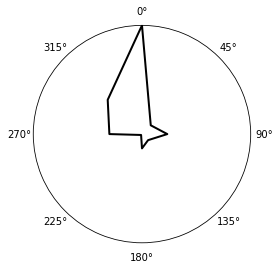

cell id 517420247
g_dsi_dg 0.221057919778054
dsi_dg 0.218620612288278
p_dg 1.13444222132536e-22
pref_dir_dg 225.0
new_dsi_cell 0.5936163914721018


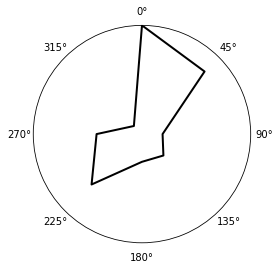

cell id 517420418
g_dsi_dg 0.983418141283648
dsi_dg 1.08460889713801
p_dg 3.40822255519601e-39
pref_dir_dg 315.0
new_dsi_cell 0.7628724106235008


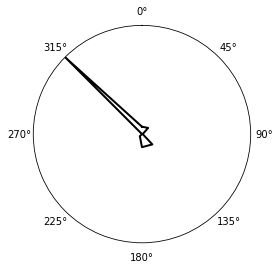

cell id 517420452
g_dsi_dg 0.558024523384968
dsi_dg 0.762979215433501
p_dg 5.8665409342673e-16
pref_dir_dg 45.0
new_dsi_cell 0.5233902995423595


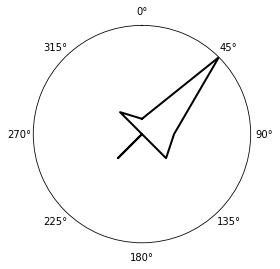

cell id 517420573
g_dsi_dg 0.438434452084507
dsi_dg 0.689473472717982
p_dg 3.62722142715756e-11
pref_dir_dg 225.0
new_dsi_cell 0.6910596497060099


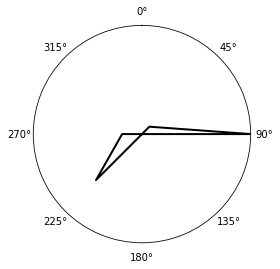

cell id 517420735
g_dsi_dg 0.48920188801802
dsi_dg 0.634904137033386
p_dg 0.00698001025117025
pref_dir_dg 225.0
new_dsi_cell 0.6909299475245202


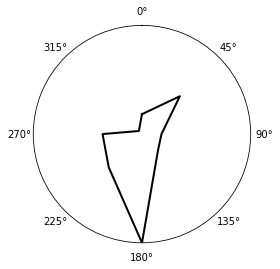

cell id 517420741
g_dsi_dg 0.482328226408032
dsi_dg 1.66320280640752
p_dg 0.0201318098016542
pref_dir_dg 270.0
new_dsi_cell 0.7379653721634287


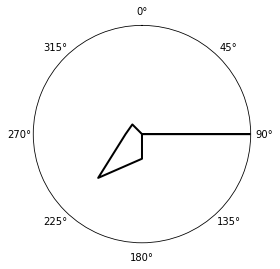

cell id 517420857
g_dsi_dg 1.0
dsi_dg nan
p_dg 0.112634888498636
pref_dir_dg nan
new_dsi_cell 1.0


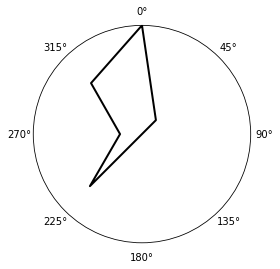

cell id 517421085
g_dsi_dg 0.987296851810403
dsi_dg 1.07863962584032
p_dg 1.22270494355591e-05
pref_dir_dg 225.0
new_dsi_cell 0.5193772661620975


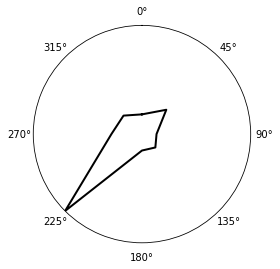

cell id 517421098
g_dsi_dg 0.539012514166776
dsi_dg 0.935321851592649
p_dg 0.0035027418508809
pref_dir_dg 180.0
new_dsi_cell 0.6691053144213681


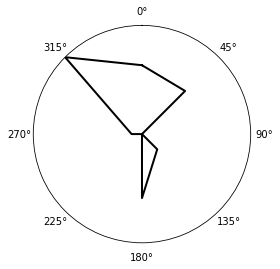

cell id 517421374
g_dsi_dg 0.377935019353817
dsi_dg 0.671993452656465
p_dg 7.14200119699427e-25
pref_dir_dg 90.0
new_dsi_cell 0.5168286825402795


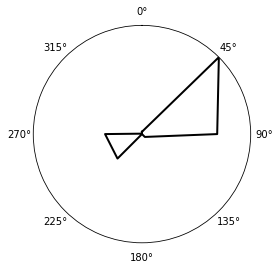

cell id 517421717
g_dsi_dg 0.296236074085501
dsi_dg 0.443556252412256
p_dg 1.53657428717864e-05
pref_dir_dg 225.0
new_dsi_cell 0.8238749376587039


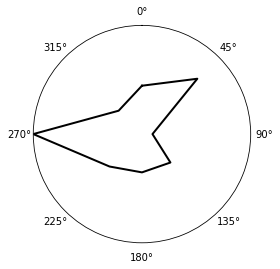

cell id 586180112
g_dsi_dg 0.605580120080405
dsi_dg 1.09196314886361
p_dg 0.0480915327241838
pref_dir_dg 225.0
new_dsi_cell 1.0


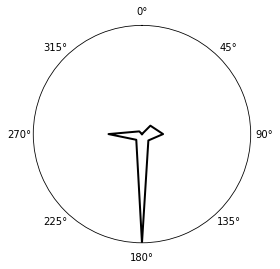

cell id 586181540
g_dsi_dg 0.882952366895696
dsi_dg nan
p_dg 0.00222228444879412
pref_dir_dg 270.0
new_dsi_cell 1.0


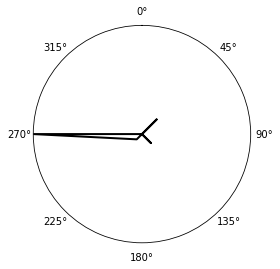

cell id 586183081
g_dsi_dg 0.241764064684105
dsi_dg 0.910470419517597
p_dg 1.81647980345134e-05
pref_dir_dg 225.0
new_dsi_cell 0.7101484069974668


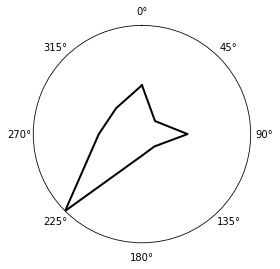

cell id 586183153
g_dsi_dg 0.409718952296382
dsi_dg 0.477893532607537
p_dg 3.46544946626015e-06
pref_dir_dg 90.0
new_dsi_cell 0.631137007963022


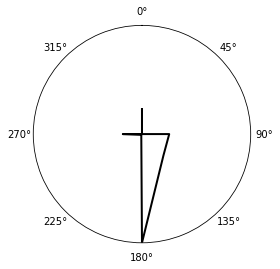

cell id 586183159
g_dsi_dg 0.823532932459045
dsi_dg 0.854531631527332
p_dg 0.0103056541850064
pref_dir_dg 90.0
new_dsi_cell 0.5597106499682405


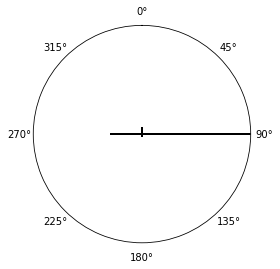

cell id 586183175
g_dsi_dg 0.618550915003317
dsi_dg nan
p_dg 0.329353565905194
pref_dir_dg nan
new_dsi_cell 0.7794000508843429


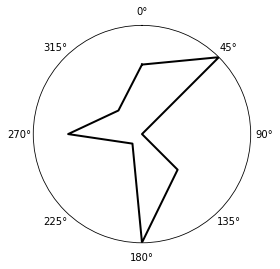

In [17]:
for i in range(len(thetas)):
    cell_id = cell_ids[i]
    print ("cell id", cell_id)
    cell_df = filtered_cells[filtered_cells.cell_specimen_id == cell_id]
    print ("g_dsi_dg", cell_df.g_dsi_dg.values[0])
    print ("dsi_dg", cell_df.dsi_dg.values[0])
    print ("p_dg", cell_df.p_dg.values[0])
    print ("pref_dir_dg", cell_df.pref_dir_dg.values[0])
    print ("new_dsi_cell", cell_df.new_dsi_cell.values[0])
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot(axes, thetas[i], rs[i])
    plt.show()